# Walmart Project


Part 1 : make an EDA and all the necessary preprocessings to prepare data for machine learning


In [100]:
# import
import os
import json
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error 
from sklearn.linear_model import LinearRegression

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio




import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)





In [101]:
## read dataset
dataset_file = "/content/JEDHA_Files/Walmart_Store_sales.csv"
walmart_df = pd.read_csv(dataset_file)

# Basic stats
print("Number of rows : {}".format(walmart_df.shape[0]))
print()

print("Display of dataset: ")
display(walmart_df.head())
print()

print("Basics statistics: ")
data_desc = walmart_df.describe(include='all')
display(data_desc)
print()

print("General information: ")
display(walmart_df.info())
print()

print("Percentage of missing values: ")
display(100*walmart_df.isnull().sum()/walmart_df.shape[0])

Number of rows : 150

Display of dataset: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092



Basics statistics: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,07-01-2011,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000



General information: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         150 non-null    float64
 1   Date          132 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  138 non-null    float64
 4   Temperature   132 non-null    float64
 5   Fuel_Price    136 non-null    float64
 6   CPI           138 non-null    float64
 7   Unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.5+ KB


None


Percentage of missing values: 


Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

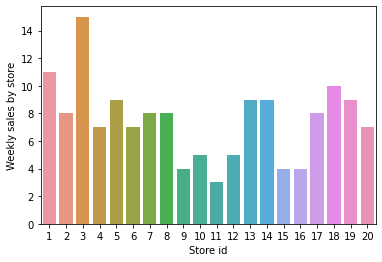

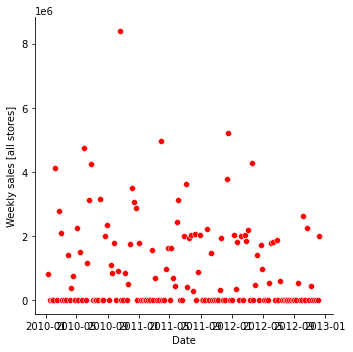

In [123]:
#  Visualizations
walmart_store_df = pd.DataFrame(walmart_df.groupby(["Store"]).size()).reset_index()
walmart_store_df = walmart_store_df.rename(columns={0: "Weekly sales by store","Store" : "Store id"})
walmart_sales_df = walmart_df[["Date", "Store", "Weekly_Sales"]].copy()
walmart_sales_df["Date"] = pd.to_datetime(walmart_sales_df["Date"])
walmart_sales_df = walmart_sales_df.resample('W-Mon', on='Date') \
                                   .sum() \
                                   .drop(columns=["Store"])# SALES IN THE WEEK
                                                                                

walmart_sales_df = walmart_sales_df.rename(columns={"Weekly_Sales": "Weekly sales [all stores]"}) 



walmart_store_df["Store id"] = walmart_store_df["Store id"].astype(int)



sns.barplot(x="Store id", y="Weekly sales by store", data=walmart_store_df)

sns.relplot(x="Date", y="Weekly sales [all stores]", data = walmart_sales_df,color='R')




KeyError: ignored

## Data preprocessing

In [36]:
walmart_df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

In [37]:
# drop lines where target values are missing
walmart_df.dropna(subset = ["Weekly_Sales"], inplace=True)

print("Percentage of missing values in target Weekly_Sales: ")
display(100*walmart_df["Weekly_Sales"].isnull().sum()/walmart_df.shape[0])

Percentage of missing values in target Weekly_Sales: 


0.0

In [38]:
# create usable features from the Date column
walmart_df["Date"] = pd.to_datetime(walmart_df["Date"])
walmart_df["Year"] = walmart_df['Date'].dt.year
walmart_df["Month"] = walmart_df['Date'].dt.month
walmart_df["Day"] = walmart_df['Date'].dt.day
walmart_df["DayOfWeek"] = walmart_df['Date'].dt.dayofweek

# drop Date
useless_cols = ['Date']
walmart_df = walmart_df.drop(useless_cols, axis=1)

display(walmart_df[["Year", "Month", "Day", "DayOfWeek"]].sample(3))

,Year,Month,Day,DayOfWeek
44,2010.0,12.0,2.0,3.0
89,NaN,NaN,NaN,NaN
32,2012.0,10.0,2.0,1.0


In [39]:
walmart_df.columns

Index(['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment', 'Year', 'Month', 'Day', 'DayOfWeek'],
      dtype='object')

In [40]:
# drop lines containing invalid values or outliers
# # helper function : outliers mask
def outliers_mask(df, column, s_range=3) :
    mask = (df[column] < df[column].mean() + s_range*df[column].std()) & \
            (df[column] > df[column].mean() - s_range*df[column].std())
    
    # display(mask)
    return mask
# Temperature
mask_T = outliers_mask(walmart_df, "Temperature")
walmart_df = walmart_df.loc[mask_T,:]

print('Dropping outliers in Temperature...')
print('Done. Number of lines remaining : ', walmart_df.shape[0])
print()

# Fuel price
mask_FP = outliers_mask(walmart_df, "Fuel_Price")
walmart_df = walmart_df.loc[mask_FP,:]

print('Dropping outliers in Fuel Price...')
print('Done. Number of lines remaining : ', walmart_df.shape[0])
print()

# CPI
mask_CPI = outliers_mask(walmart_df, "CPI")
walmart_df = walmart_df.loc[mask_CPI,:]

print('Dropping outliers in CPI...')
print('Done. Number of lines remaining : ', walmart_df.shape[0])
print()

# Unemployment
mask_U = outliers_mask(walmart_df, "Unemployment")
walmart_df = walmart_df.loc[mask_U,:]

print('Dropping outliers in Unemployment...')
print('Done. Number of lines remaining : ', walmart_df.shape[0])
print()


Dropping outliers in Temperature...
Done. Number of lines remaining :  121

Dropping outliers in Fuel Price...
Done. Number of lines remaining :  109

Dropping outliers in CPI...
Done. Number of lines remaining :  102

Dropping outliers in Unemployment...
Done. Number of lines remaining :  90



In [124]:
walmart_df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


In [42]:
# separate target variable from others
target = 'Weekly_Sales'
Y_df = walmart_df.loc[:,target]
X_df = walmart_df.loc[:,[c for c in walmart_df.columns if c!=target]] # All columns are kept, except the target

print("Separating labels from features...")
print("Target")
print(Y_df.head())

print("\nFeatures")
print(X_df.head())
print()

Separating labels from features...
Target
0    1572117.54
1    1807545.43
4    1644470.66
6     695396.19
7    2203523.20
Name: Weekly_Sales, dtype: float64

Features
   Store  Holiday_Flag  Temperature  Fuel_Price  ...    Year  Month   Day  DayOfWeek
0    6.0           NaN        59.61       3.045  ...  2011.0    2.0  18.0        4.0
1   13.0           0.0        42.38       3.435  ...  2011.0    3.0  25.0        4.0
4    6.0           0.0        78.89       2.759  ...  2010.0    5.0  28.0        4.0
6   15.0           0.0        69.80       4.069  ...  2011.0    3.0   6.0        6.0
7   20.0           0.0        39.93       3.617  ...  2012.0    3.0   2.0        4.0

[5 rows x 10 columns]



In [43]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X = X_df.values
Y = Y_df.tolist()
print("...Done")
print(X[0:5,:])
print()
print(Y[0:5])

Convert pandas DataFrames to numpy arrays...
...Done
[[6.00000000e+00            nan 5.96100000e+01 3.04500000e+00
  2.14777523e+02 6.85800000e+00 2.01100000e+03 2.00000000e+00
  1.80000000e+01 4.00000000e+00]
 [1.30000000e+01 0.00000000e+00 4.23800000e+01 3.43500000e+00
  1.28616064e+02 7.47000000e+00 2.01100000e+03 3.00000000e+00
  2.50000000e+01 4.00000000e+00]
 [6.00000000e+00 0.00000000e+00 7.88900000e+01 2.75900000e+00
  2.12412888e+02 7.09200000e+00 2.01000000e+03 5.00000000e+00
  2.80000000e+01 4.00000000e+00]
 [1.50000000e+01 0.00000000e+00 6.98000000e+01 4.06900000e+00
  1.34855161e+02 7.65800000e+00 2.01100000e+03 3.00000000e+00
  6.00000000e+00 6.00000000e+00]
 [2.00000000e+01 0.00000000e+00 3.99300000e+01 3.61700000e+00
  2.13023623e+02 6.96100000e+00 2.01200000e+03 3.00000000e+00
  2.00000000e+00 4.00000000e+00]]

[1572117.54, 1807545.43, 1644470.66, 695396.19, 2203523.2]


#### Sklearn preprocessing

**Explanatory variables (X)**
We need to identify which columns contain categorical variables and which columns contain numerical variables, as they will be treated differently.

 - Categorical variables : Store, Holiday_Flag
 - Numerical variables : Temperature, Fuel_Price, CPI, Unemployment, Year, Month, Day, DayOfWeek

In [60]:
# split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

display(X_train[:5])
display(X_df)


array([[1.60000000e+01, 0.00000000e+00, 6.17900000e+01, 2.71100000e+00,
        1.89523128e+02, 6.86800000e+00, 2.01000000e+03, 9.00000000e+00,
        7.00000000e+00, 1.00000000e+00],
       [5.00000000e+00, 0.00000000e+00, 6.91700000e+01, 3.59400000e+00,
        2.24019287e+02, 5.42200000e+00, 2.01200000e+03, 1.00000000e+01,
        1.90000000e+01, 4.00000000e+00],
       [1.90000000e+01, 0.00000000e+00, 3.32600000e+01, 3.78900000e+00,
        1.33958742e+02, 7.77100000e+00, 2.01100000e+03, 3.00000000e+00,
        2.50000000e+01, 4.00000000e+00],
       [8.00000000e+00, 0.00000000e+00, 8.29200000e+01, 3.55400000e+00,
        2.19070197e+02, 6.42500000e+00, 2.01100000e+03, 8.00000000e+00,
        1.90000000e+01, 4.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 7.47800000e+01, 2.85400000e+00,
        2.10337426e+02, 7.80800000e+00, 2.01000000e+03, 5.00000000e+00,
        1.40000000e+01, 4.00000000e+00]])

,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,DayOfWeek
0,6.0,NaN,59.61,3.045,214.777523,6.858,2011.0,2.0,18.0,4.0
1,13.0,0.0,42.38,3.435,128.616064,7.470,2011.0,3.0,25.0,4.0
4,6.0,0.0,78.89,2.759,212.412888,7.092,2010.0,5.0,28.0,4.0
6,15.0,0.0,69.80,4.069,134.855161,7.658,2011.0,3.0,6.0,6.0
7,20.0,0.0,39.93,3.617,213.023623,6.961,2012.0,3.0,2.0,4.0
...,...,...,...,...,...,...,...,...,...,...
139,7.0,0.0,50.60,3.804,197.588605,8.090,2012.0,5.0,25.0,4.0
143,3.0,0.0,78.53,2.705,214.495838,7.343,2010.0,4.0,6.0,1.0
144,3.0,0.0,73.44,3.594,226.968844,6.034,2012.0,10.0,19.0,4.0
145,14.0,0.0,72.62,2.780,182.442420,8.899,2010.0,6.0,18.0,4.0


In [45]:
# cat & num variables
cat_vars = ["Store", "Holiday_Flag"]
num_vars = ["Temperature", "Fuel_Price", "Unemployment",
            "Year", "Month", "Day", "DayOfWeek"]

In [22]:
# pipeline categorical & numerical
# helper function : var_index
def var_index(df, name) :
    return df.columns.to_list().index(name)

# pipeline for numeric features
numeric_features = [var_index(X_df, name) for name in num_vars]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])


# Create pipeline for categorical features
categorical_features = [var_index(X_df, name) for name in cat_vars]
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])


display(numeric_features)
display(categorical_features)

[2, 3, 5, 6, 7, 8, 9]

[0, 1]

In [46]:
# preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [47]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
X_train_processed = preprocessor.fit_transform(X_train)
print(X_train_processed[0:5,:])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
X_test_processed = preprocessor.transform(X_test)
print(X_test_processed[0:5,:])
print()

Performing preprocessings on train set...
[[ 0.04260362 -1.26840641 -0.55534542 -1.1763434   0.74406169 -1.10466577
  -2.03634567  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          1.          0.          0.          0.
   0.          0.        ]
 [ 0.4592769   0.58058829 -2.12734441  1.47042924  1.06485475  0.43473943
   0.19639882  0.          0.          0.          1.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [-1.5681943   0.98891668  0.42633859  0.14704292 -1.18069669  1.20444204
   0.19639882  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.
   0.          0.        ]
 [ 1.23559907  0.49682862 -1.03694678  0.14704292  0.42326862

Part 2 : train a linear regression model (baseline)


In [48]:
# px 
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg"

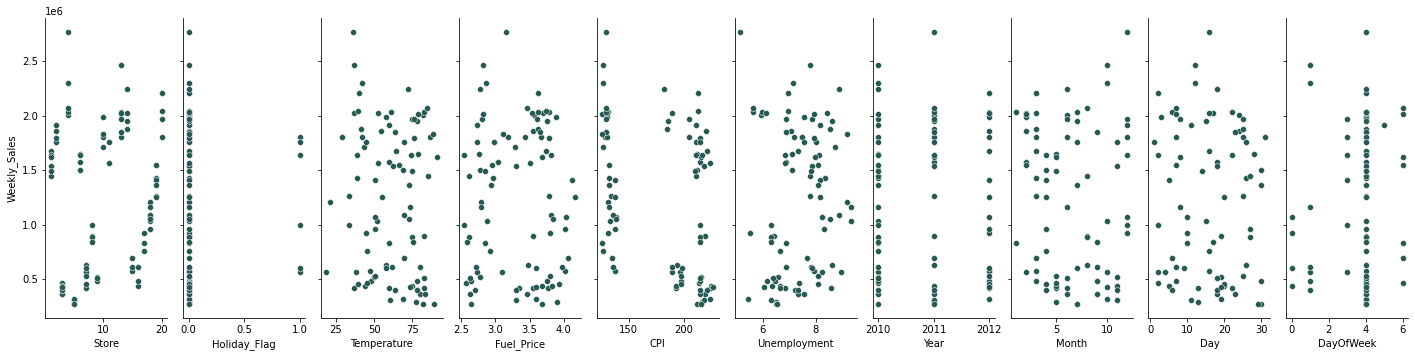

In [57]:
#Correlation

# visualize the relationship between the features and the response using scatterplots
sns.pairplot(data, x_vars=X_df.columns.to_list(), y_vars='Weekly_Sales', height=5, aspect=0.4);

In [62]:
#train model

display(X_train_processed[0:3, :])
display(Y_train[0:3])

array([[ 0.04260362, -1.26840641, -0.55534542, -1.1763434 ,  0.74406169,
        -1.10466577, -2.03634567,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.4592769 ,  0.58058829, -2.12734441,  1.47042924,  1.06485475,
         0.43473943,  0.19639882,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.5681943 ,  0.98891668,  0.42633859,  0.14704292, -1.18069669,
         1.20444204,  0.19639882,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       

[614253.33, 313358.15, 1266564.94]

In [63]:
# Train model
model = LinearRegression()

print("Training model...")
model.fit(X_train_processed, Y_train) 
print("...Done.")

Training model...
...Done.


In [65]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = model.predict(X_train_processed)
print("...Done.")
print(Y_train_pred[0:5])
print()

Predictions on training set...
...Done.
[ 629520.08881436  304800.73299578 1317757.85494102  876285.32175938
 1585744.31449943]



In [66]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = model.predict(X_test_processed)
print("...Done.")
print(Y_test_pred[0:5])
print()

Predictions on test set...
...Done.
[1569787.1944313   691281.31601519 1881546.82452149 1775871.58436869
  358042.40863554]



In [67]:
# R-squared scores
r2_train = model.score(X_train_processed, Y_train)
r2_test = model.score(X_test_processed, Y_test)

print("R2 accuracy on training set : ", r2_train)
print("R2 accuracy on test set : ", r2_test)

R2 accuracy on training set :  0.9851825826277352
R2 accuracy on test set :  0.9263462047509957


In [70]:
# RMSE scores
rmse_train = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
rmse_test = np.sqrt(mean_squared_error(Y_test, Y_test_pred))

print("Accuracy on training set : ", rmse_train)
print("Accuracy on test set : ", rmse_test)

Accuracy on training set :  78702.67016669102
Accuracy on test set :  192723.49454276162


In [72]:
# feature importance
feature_importance = list(zip(X_df.columns.to_list(), model.coef_))
display(feature_importance)

[('Store', -373.0270261716758),
 ('Holiday_Flag', -35080.19641466622),
 ('Temperature', 20981.60862768704),
 ('Fuel_Price', 18895.416316918658),
 ('CPI', 17938.68986877049),
 ('Unemployment', -49288.378464938425),
 ('Year', -15871.32002169802),
 ('Month', 237852.89538487815),
 ('Day', -1170482.7423773808),
 ('DayOfWeek', 579567.0345226234)]

Part 3 : avoid overfitting by training a regularized regression model

In [74]:
# Perform 3-fold cross-validation to evaluate the generalized R2 score obtained with a Ridge model
print("3-fold cross-validation...")
regressor = Ridge()
scores = cross_val_score(regressor, X_train_processed, Y_train, cv=3)
print('The cross-validated R2-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())

3-fold cross-validation...
The cross-validated R2-score is :  0.7205594875436608
The standard deviation is :  0.10471044524026027


In [76]:
# Perform grid search
print("Grid search...")
regressor = Ridge()
# Grid of values to be tested
params = {
    'alpha': [0.0, 0.1, 0.5, 1.0] # 0 corresponds to no regularization
}
gridsearch = GridSearchCV(regressor, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train_processed, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best R2 score : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'alpha': 0.1}
Best R2 score :  0.8309460863232311


In [77]:
# Predictions on training set
# The model has already be re-trained on all the training set at the end of the grid search, so we can directly use it !
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train_processed)
print("...Done.")
print(Y_train_pred[0:2])
print()

Predictions on training set...
...Done.
[672917.25071811 318842.75097782]



In [78]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test_processed)
print("...Done.")
print(Y_test_pred[:2])
print()

Predictions on test set...
...Done.
[1566423.97574778  666281.02684722]



In [80]:
# Print R^2 scores on train/test sets for the Ridge model with optimal value of the regularization strength
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.9828134262111804
R2 score on test set :  0.9195008830367617


In [81]:
# RMSE scores
rmse_train = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
rmse_test = np.sqrt(mean_squared_error(Y_test, Y_test_pred))

print("Accuracy on training set : ", rmse_train)
print("Accuracy on test set : ", rmse_test)

Accuracy on training set :  84761.34967633682
Accuracy on test set :  201480.33068212628
